In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r"C:\Users\praba\Downloads\customer_segmentation.csv\customer_segmentation.csv", encoding='latin1')


In [3]:
print(df.head())
print(df.info())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo   

In [4]:
import numpy as np

# Parse dates
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Create Revenue column
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Define snapshot date (end of observation period)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Aggregate to customer level
customer_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'Revenue': ['sum', 'mean']                                # Monetary / AOV
}).reset_index()

# Rename columns
customer_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'AOV']

print(customer_df.head())

   CustomerID  Recency  Frequency  Monetary        AOV
0     12346.0      326          2      0.00   0.000000
1     12347.0        2          7   4310.00  23.681319
2     12348.0       75          4   1797.24  57.975484
3     12349.0       19          1   1757.55  24.076027
4     12350.0      310          1    334.40  19.670588


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# Define features and target
X = customer_df[['Recency', 'Frequency', 'AOV']]
y = customer_df['Monetary']  # LTV

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 1073.58
RMSE: 5970.36


In [8]:
# Predict for all customers
customer_df['Predicted_LTV'] = model.predict(X)

# Segment based on LTV quantiles
customer_df['Segment'] = pd.qcut(customer_df['Predicted_LTV'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

print(customer_df[['CustomerID', 'Predicted_LTV', 'Segment']].head())


   CustomerID  Predicted_LTV    Segment
0     12346.0      -0.161358        Low
1     12347.0    2667.790039  Very High
2     12348.0    1570.198608       High
3     12349.0     444.732086     Medium
4     12350.0     318.263733        Low


In [9]:
# Save predictions
customer_df.to_csv("predicted_ltv.csv", index=False)

# Optional: Save model
import joblib
joblib.dump(model, 'ltv_model_xgboost.pkl')



['ltv_model_xgboost.pkl']

C:\Users\praba\AppData\Local\Temp\ipykernel_11844\2378240904.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=customer_df, x='Segment', y='Predicted_LTV', palette=palette)


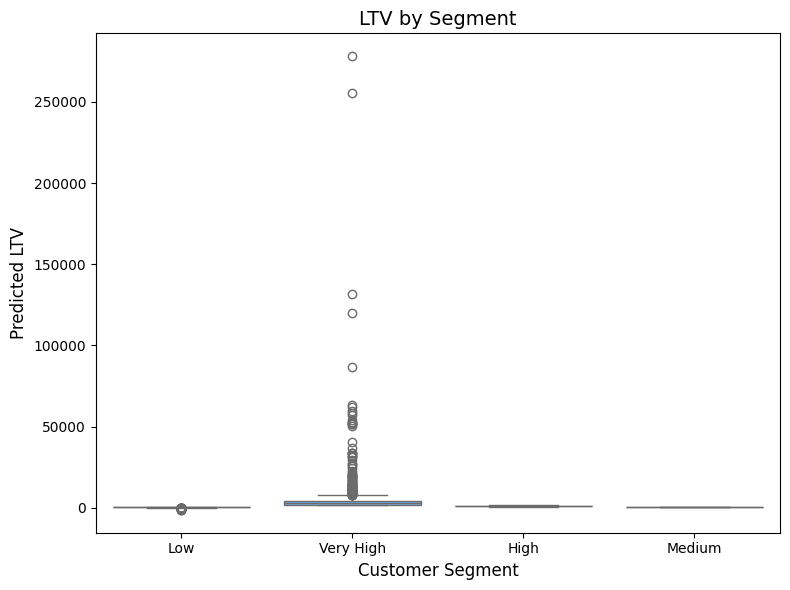

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Custom color palette (mapped by segment name)
palette = {
    'Low': '#FF9999',
    'Medium': '#FFD580',
    'High': '#8FD9B6',
    'Very High': '#66B3FF'
}

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=customer_df, x='Segment', y='Predicted_LTV', palette=palette)

plt.title("LTV by Segment", fontsize=14)
plt.xlabel("Customer Segment", fontsize=12)
plt.ylabel("Predicted LTV", fontsize=12)
plt.tight_layout()
plt.show()


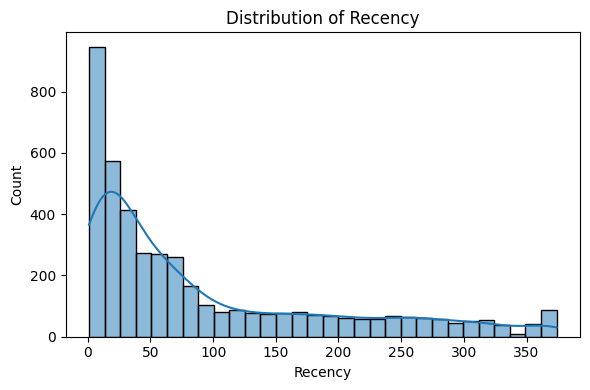

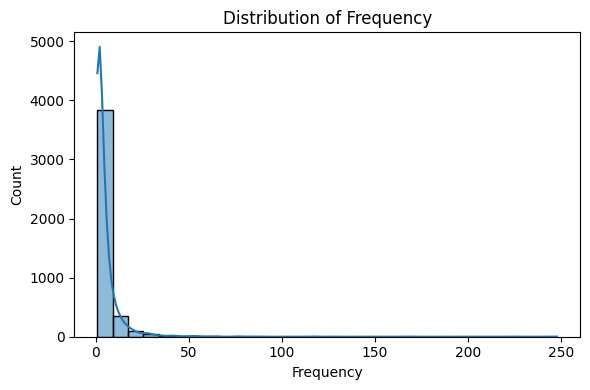

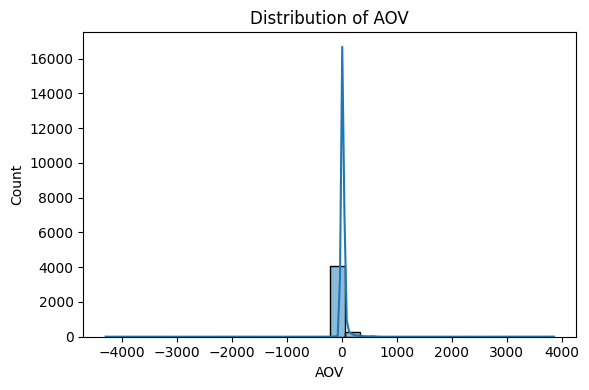

In [19]:
features = ['Recency', 'Frequency', 'AOV']
for col in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(customer_df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


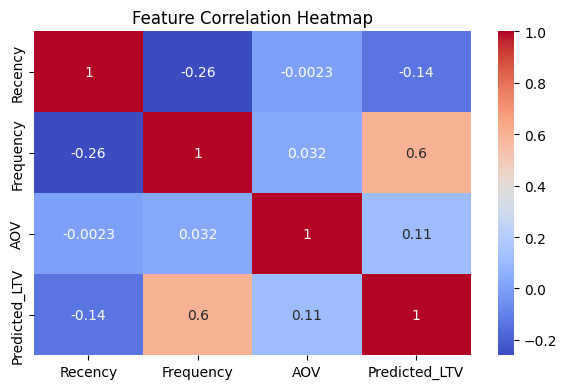

In [20]:
plt.figure(figsize=(6, 4))
sns.heatmap(customer_df[['Recency', 'Frequency', 'AOV', 'Predicted_LTV']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


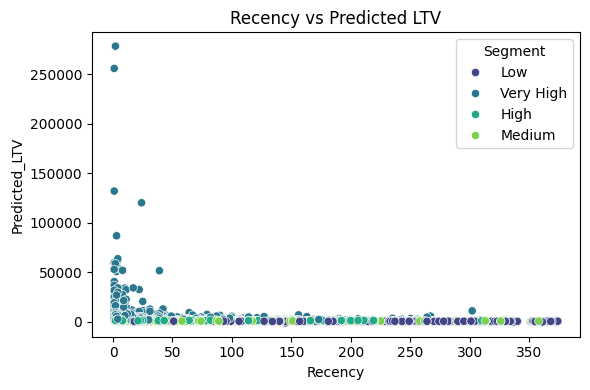

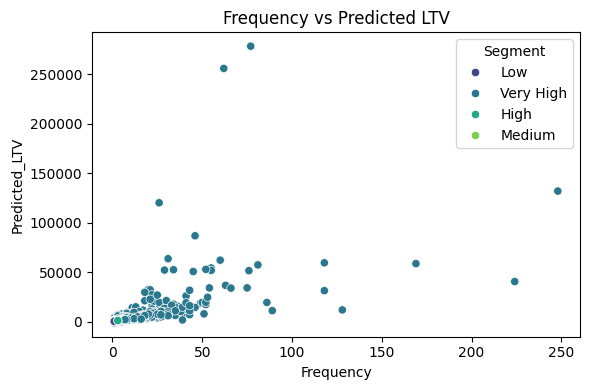

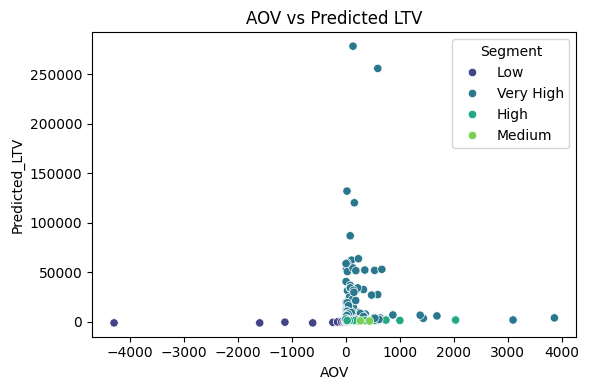

In [21]:
for col in ['Recency', 'Frequency', 'AOV']:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=customer_df, x=col, y='Predicted_LTV', hue='Segment', palette='viridis')
    plt.title(f"{col} vs Predicted LTV")
    plt.tight_layout()
    plt.show()


In [22]:
customer_df.to_csv("final_ltv_predictions.csv", index=False)
print("CSV exported: final_ltv_predictions.csv")

CSV exported: final_ltv_predictions.csv
